<a href="https://colab.research.google.com/github/SaraBabakN/hello-world/blob/master/new_maxpool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime
import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

train_set = torchvision.datasets.CIFAR10('./dataset', train=True, download=True,
                                         transform=transforms.Compose([transforms.ToTensor()]))


def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

0it [00:00, ?it/s]

100%|█████████▉| 170065920/170498071 [00:12<00:00, 16974992.86it/s]

Extracting ./dataset/cifar-10-python.tar.gz to ./dataset


In [0]:
lr = 0.01
batch_size = 200
dataset_size = 50000
epoch_num = 20
epsilon = 0.000001
treshold = 0.001 

In [0]:
def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

In [0]:
class BasicBlock(nn.Module): 
    expansion = 1 
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        norm_layer = nn.BatchNorm2d
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out   

In [0]:
class myModel(nn.Module):

    def __init__(self, block,groups=1, width_per_group=64):
        super(myModel, self).__init__()
        norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.inplanes = 64
        self.dilation = 1
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3,64, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1 = norm_layer(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.newMax =  nn.MaxPool2d(2, stride=2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2, stride=2)
        self.layer1 = self._make_layer(block, 64)
        self.layer2 = self._make_layer(block, 64)
        self.layer3 = self._make_layer(block, 128, stride=2)
        self.layer4 = self._make_layer(block, 128,)
        self.layer5 = self._make_layer(block, 256, stride=2)
        self.layer6 = self._make_layer(block, 256)
        self.layer7 = self._make_layer(block, 512, stride=2)
        self.layer8 = self._make_layer(block, 512)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 , 10)

    def _make_layer(self, block, planes, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes, stride),
                norm_layer(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes
        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)

        x , indices = self.newMax(x)
        x = self.unpool(x, indices)

        x = self.layer2(x)

        x , indices= self.newMax(x)
        x = self.unpool(x, indices)

        x = self.layer3(x)

        x , indices= self.newMax(x)
        x = self.unpool(x, indices)

        x = self.layer4(x)

        x, indices = self.newMax(x)
        x = self.unpool(x, indices)

        x = self.layer5(x)

        x, indices = self.newMax(x)
        x = self.unpool(x, indices)

        x = self.layer6(x)

        x , indices= self.newMax(x)
        x = self.unpool(x, indices)

        x = self.layer7(x)
        x = self.layer8(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [0]:
def myResnet(pretrained=False, progress=True, **kwargs):
    return myModel(BasicBlock,**kwargs)

In [0]:
myNet = myResnet().cuda()
data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
optimizer = optim.Adam(myNet.parameters(), lr=lr)

In [0]:
for epoch in range(epoch_num):
    correct = 0 
    for batch in data_loader:
        images, labels = batch
        images = images.cuda() 
        labels = labels.cuda()
        preds = myNet(images)
          
        loss = nn.functional.cross_entropy(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        correct = correct + get_num_correct(preds,labels)
    print("epoch", epoch, "accuracy" , correct)

In [0]:
x = myNet.conv1(images)
x = myNet.bn1(x)
x = myNet.relu(x)
x = myNet.maxpool(x)
x = myNet.layer1(x)
x = myNet.layer2(x)
x , indices= myNet.newMax(x)
x = myNet.unpool(x, indices)
modulList = list(myNet.layer3.modules())
y = modulList[7](x)
z = modulList[2](x)
z = modulList[3](z)
z = modulList[4](z)
z = modulList[5](z)
z = modulList[6](z)
l3 = myNet.layer3(x)


Text(0.5, 1.0, 'layer 2 - image101')

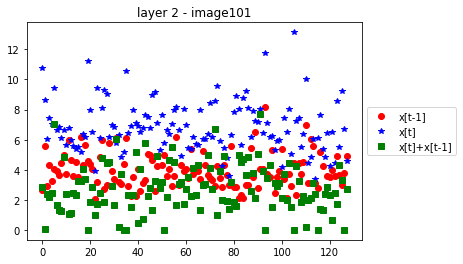

In [20]:
# Singel image, different filters 
imageNumber = 100 
# Whole layer 
a = torch.norm(y[imageNumber].clone().detach().cpu(),dim=(1,2))
b = torch.norm(z[imageNumber].clone().detach().cpu(),dim=(1,2))
c = torch.norm(l3[imageNumber].clone().detach().cpu(),dim=(1,2))
t= range (128)
plt.plot(t,a[t] , 'ro' , label = "x[t-1]" )
plt.plot(t,b[t] , 'b*' , label = "x[t]")
plt.plot(t,c[t] ,  'gs' , label = "x[t]+x[t-1]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
name = "layer 2 - image" + str(imageNumber + 1)
plt.title(name)
# plt.savefig('/content/drive/My Drive/data1/' + name )

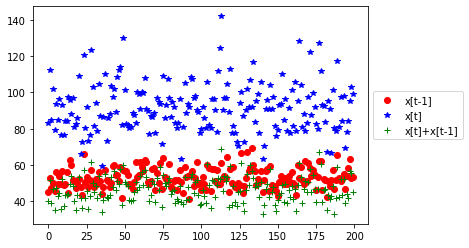

In [12]:
# Whole layer 
a = torch.norm(y.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
b = torch.norm(z.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
c = torch.norm((l3).reshape(batch_size,-1).clone().detach().cpu(),dim=1)
t= range (batch_size)
plt.plot(t,a[t] , 'ro' , label = "x[t-1]" )
plt.plot(t,b[t] , 'b*' , label = "x[t]")
plt.plot(t,c[t] ,  "g+" , label = "x[t]+x[t-1]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig('/content/drive/My Drive/data1/layer3')

In [14]:
a = torch.norm(y.clone().detach().cpu(),dim=(2,3))
b = torch.norm(z.clone().detach().cpu(),dim=(2,3))
c = torch.div(b , a + epsilon) 
print (torch.nonzero(c < treshold).shape)
c = torch.div(a , b + epsilon) 
print (torch.nonzero(c < treshold).shape)

torch.Size([0, 2])
torch.Size([0, 2])


In [0]:
x , indices= myNet.newMax(l3)
l3 = myNet.unpool(x, indices)
l4 = myNet.layer4(l3)
modulList = list(myNet.layer5.modules())
x , indices= myNet.newMax(l4)
l4 = myNet.unpool(x, indices)
y5 = modulList[7](l4)
z5 = modulList[2](l4)
z5 = modulList[3](z5)
z5 = modulList[4](z5)
z5 = modulList[5](z5)
z5 = modulList[6](z5)
l5 = myNet.layer5(l4)

In [16]:
a = torch.norm(y5.clone().detach().cpu(),dim=(2,3))
b = torch.norm(z5.clone().detach().cpu(),dim=(2,3))
c = torch.div(b , a+epsilon) 
print (torch.nonzero(c < treshold).shape)
c = torch.div( a , b+epsilon) 
print (torch.nonzero(c < treshold).shape)

torch.Size([0, 2])
torch.Size([0, 2])


Text(0.5, 1.0, 'layer 3 - image101')

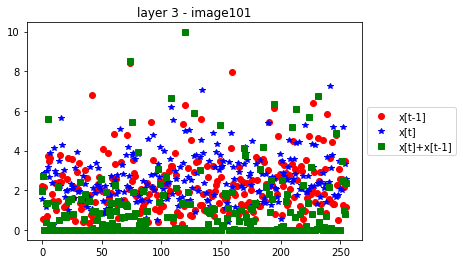

In [21]:
# Singel image, different filters 
imageNumber = 100 
# Whole layer 
a = torch.norm(y5[imageNumber].clone().detach().cpu(),dim=(1,2))
b = torch.norm(z5[imageNumber].clone().detach().cpu(),dim=(1,2))
c = torch.norm(l5[imageNumber].clone().detach().cpu(),dim=(1,2))
t= range (256)
plt.plot(t,a[t] , 'ro' , label = "x[t-1]" )
plt.plot(t,b[t] , 'b*' , label = "x[t]")
plt.plot(t,c[t] , 'gs' , label = "x[t]+x[t-1]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
name = "layer 3 - image" + str(imageNumber + 1)
plt.title(name)

Text(0.5, 1.0, 'layer 3 - image151')

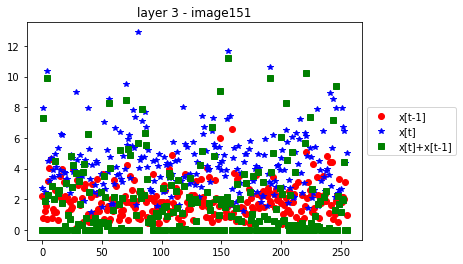

In [22]:
# Singel image, different filters 
imageNumber = 150 
# Whole layer 
a = torch.norm(y5[imageNumber].clone().detach().cpu(),dim=(1,2))
b = torch.norm(z5[imageNumber].clone().detach().cpu(),dim=(1,2))
c = torch.norm(l5[imageNumber].clone().detach().cpu(),dim=(1,2))
t= range (256)
plt.plot(t,a[t] , 'ro' , label = "x[t-1]" )
plt.plot(t,b[t] , 'b*' , label = "x[t]")
plt.plot(t,c[t] , 'gs' , label = "x[t]+x[t-1]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
name = "layer 3 - image" + str(imageNumber + 1)
plt.title(name)

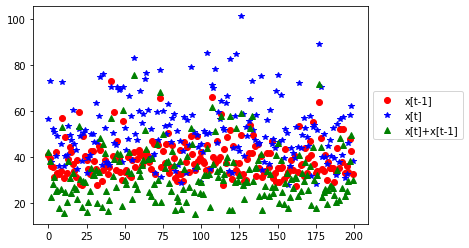

In [23]:
a = torch.norm(y5.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
b = torch.norm(z5.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
c = torch.norm(l5.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
t= range (batch_size)
plt.plot(t,a[t] , 'ro' , label = "x[t-1]")
plt.plot(t,b[t] , 'b*' , label = "x[t]")
plt.plot(t,c[t] , 'g^' , label = "x[t]+x[t-1]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [0]:
x , indices= myNet.newMax(l5)
l5 = myNet.unpool(x, indices)
l6= myNet.layer6(l5)
x , indices= myNet.newMax(l6)
l6 = myNet.unpool(x, indices)
modulList = list(myNet.layer7.modules())
y7 = modulList[7](l6)
z7 = modulList[2](l6)
z7 = modulList[3](z7)
z7 = modulList[4](z7)
z7 = modulList[5](z7)
z7 = modulList[6](z7)
l7 = myNet.layer7(l6) 

In [25]:
a = torch.norm(y7.clone().detach().cpu(),dim=(2,3))
b = torch.norm(z7.clone().detach().cpu(),dim=(2,3))
c = torch.div(b , a+epsilon) 
print (torch.nonzero(c < treshold).shape)
c = torch.div( a , b+epsilon) 
print (torch.nonzero(c < treshold).shape)

torch.Size([54, 2])
torch.Size([62, 2])


Text(0.5, 1.0, 'layer 4 - image101')

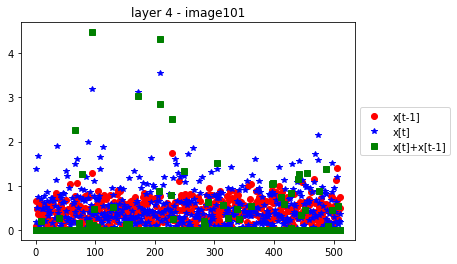

In [26]:
# Singel image, different filters 
imageNumber = 100 
# Whole layer 
a = torch.norm(y7[imageNumber].clone().detach().cpu(),dim=(1,2))
b = torch.norm(z7[imageNumber].clone().detach().cpu(),dim=(1,2))
c = torch.norm(l7[imageNumber].clone().detach().cpu(),dim=(1,2))
t= range (512)
plt.plot(t,a[t] , 'ro' , label = "x[t-1]" )
plt.plot(t,b[t] , 'b*' , label = "x[t]")
plt.plot(t,c[t] , 'gs' , label = "x[t]+x[t-1]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
name = "layer 4 - image" + str(imageNumber + 1)
plt.title(name)

Text(0.5, 1.0, 'layer 4 - image151')

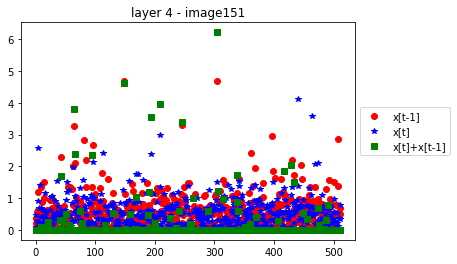

In [27]:
# Singel image, different filters 
imageNumber = 150 
# Whole layer 
a = torch.norm(y7[imageNumber].clone().detach().cpu(),dim=(1,2))
b = torch.norm(z7[imageNumber].clone().detach().cpu(),dim=(1,2))
c = torch.norm(l7[imageNumber].clone().detach().cpu(),dim=(1,2))
t= range (512)
plt.plot(t,a[t] , 'ro' , label = "x[t-1]" )
plt.plot(t,b[t] , 'b*' , label = "x[t]")
plt.plot(t,c[t] , 'gs' , label = "x[t]+x[t-1]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
name = "layer 4 - image" + str(imageNumber + 1)
plt.title(name)

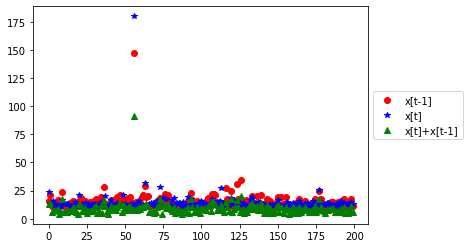

In [28]:
a = torch.norm(y7.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
b = torch.norm(z7.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
c = torch.norm(l7.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
t= range (batch_size)
plt.plot(t,a[t] , 'ro' , label = "x[t-1]" )
plt.plot(t,b[t] , 'b*' , label = "x[t]")
plt.plot(t,c[t] , 'g^' , label = "x[t]+x[t-1]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))